In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.tools.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.tools.evaluation import eval_net
from torchsummary import summary
from torch_unet.tools.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net_1 = UNet(n_channels=3, n_classes=1, depth=3, init_filters=64, padding=True, batch_norm=True, dropout=0.2)
net_1.eval()

In [4]:
net_2 = UNet(n_channels=3, n_classes=1, depth=3, init_filters=64, padding=True, batch_norm=True, dropout=0.2)
net_2.eval();

In [5]:
testset = TestSet("../Datasets/test_set_images/")

INFO: Creating dataset with 50 examples


In [36]:
img = testset[12]['image'][None, :, :, :]

In [37]:
img.shape

torch.Size([1, 3, 608, 608])

In [38]:
net_1.load_state_dict(torch.load("../models/depth4_BS128_lr0.001_PS80_ST20_WF64_padding_batchnorm_rot_dropout0.2_balance_augmentation/checkpoints/CP_epoch30.pth", map_location=device))

<All keys matched successfully>

In [39]:
net_2.load_state_dict(torch.load("../models/depth4_BS128_lr0.001_PS80_ST20_WF64_padding_batchnorm_rot_dropout0.2_dice_augmentation/checkpoints/CP_epoch33.pth", map_location=device))

<All keys matched successfully>

In [40]:
pred_1 = net_1(img)
pred_2 = net_2(img)

In [41]:
import gc
gc.collect()

12980

In [42]:
pred_1 = torch.sigmoid(pred_1)[0][0].detach().numpy()
pred_2 = torch.sigmoid(pred_2)[0][0].detach().numpy()

In [43]:
from torch_unet.utils import show_side_by_side

In [44]:
pred_1.shape, pred_2.shape

((608, 608), (608, 608))

In [45]:
new = np.concatenate([pred_1, pred_2], axis=1)

(-0.5, 607.5, 607.5, -0.5)

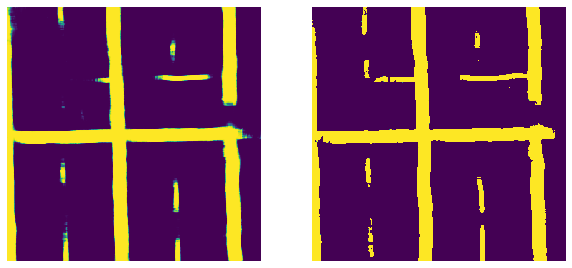

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax[0].imshow(pred_1)
ax[1].imshow(pred_2)
ax[0].axis('off');
ax[1].axis('off')
fig.

In [47]:
fig.savefig("predictions.png")

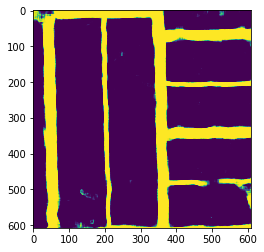

In [21]:
plt.imshow(pred_1)

In [5]:
net.eval();

In [48]:
import pandas as pd
import matplotlib.image as mpimg

In [95]:
import re
def patch_to_label(patch):
    df = np.mean(patch)
    if df > 0.5:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    #im = ((im > 0.49) * 1)
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i: i + patch_size, j: j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames[0:]:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))

In [601]:
submission_filename = "../Datasets/submission.csv"
image_filenames = []
for i in range(1, 51):
    image_filename = "../predictions/test_" + "%.d" % i + ".png"
    image_filenames.append(image_filename)

masks_to_submission(submission_filename, *image_filenames)

In [602]:
#submission = pd.read_csv("../../../../../road_segmentation/submissions/submission_17-12-2019.csv")
#submission = pd.read_csv("../Datasets/submissions/submission_best.csv")
submission = pd.read_csv("../Datasets/submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])
merged = submission.merge(solution, on='id')

In [603]:
solution.shape[0], merged.shape[0]

(72200, 72200)

In [604]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)]['id'].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)]['id'].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)]['id'].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [605]:
f1_score, precision, recall

(0.9053080119943184, 0.9265600603025897, 0.8850089997428645)

## x = np.linspace(0.1, 1, 100)
y = np.linspace(0.1, 1, 100)
def f(x, y):
    return 2*x*y/(x+y)

In [138]:
x = np.tile(x[None, :], (len(x), 1))
y = np.tile(y[:, None], (1, y.shape[0]))

In [144]:
x[-1], y[-1]

(array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
        0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
        0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
        0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
        0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
        0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
        0.37272727, 0.38181818, 0.39090909, 0.4       , 0.40909091,
        0.41818182, 0.42727273, 0.43636364, 0.44545455, 0.45454545,
        0.46363636, 0.47272727, 0.48181818, 0.49090909, 0.5       ,
        0.50909091, 0.51818182, 0.52727273, 0.53636364, 0.54545455,
        0.55454545, 0.56363636, 0.57272727, 0.58181818, 0.59090909,
        0.6       , 0.60909091, 0.61818182, 0.62727273, 0.63636364,
        0.64545455, 0.65454545, 0.66363636, 0.67272727, 0.68181818,
        0.69090909, 0.7       , 0.70909091, 0.71818182, 0.72727273,
        0.73636364, 0.74545455, 0.75454545, 0.76

In [143]:
f(x,y)[-1]

array([0.18181818, 0.19672131, 0.21138211, 0.22580645, 0.24      ,
       0.25396825, 0.26771654, 0.28125   , 0.29457364, 0.30769231,
       0.32061069, 0.33333333, 0.34586466, 0.35820896, 0.37037037,
       0.38235294, 0.39416058, 0.4057971 , 0.41726619, 0.42857143,
       0.43971631, 0.45070423, 0.46153846, 0.47222222, 0.48275862,
       0.49315068, 0.50340136, 0.51351351, 0.52348993, 0.53333333,
       0.54304636, 0.55263158, 0.5620915 , 0.57142857, 0.58064516,
       0.58974359, 0.59872611, 0.60759494, 0.6163522 , 0.625     ,
       0.63354037, 0.64197531, 0.65030675, 0.65853659, 0.66666667,
       0.6746988 , 0.68263473, 0.69047619, 0.69822485, 0.70588235,
       0.71345029, 0.72093023, 0.7283237 , 0.73563218, 0.74285714,
       0.75      , 0.75706215, 0.76404494, 0.77094972, 0.77777778,
       0.78453039, 0.79120879, 0.79781421, 0.80434783, 0.81081081,
       0.8172043 , 0.82352941, 0.82978723, 0.83597884, 0.84210526,
       0.84816754, 0.85416667, 0.86010363, 0.86597938, 0.87179

In [ ]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, MASK_THRESHOLD)

In [7]:
img, mask = dataset[0]['image'], dataset[0]['mask']
img = img[None, :, :, :]
mask = mask[None, :, :]

In [8]:
pred = net(img)

In [9]:
pred.shape

torch.Size([1, 1, 400, 400])

In [10]:
f1_score, precision, recall

NameError: name 'f1_score' is not defined

In [11]:
from torch_unet.tools.losses import dice_loss_withlogits

In [12]:
loss = dice_loss_withlogits(mask, pred)

In [13]:
loss.backward()

In [17]:
mask.dtype

torch.int64